# Springer Nature <br> Data Task 

## Introduction

### Problem 
<hr>
    <blockquote><i> The Springer Nature journals group would like to be able to automatically classify article manuscripts into academic fields of research as the manuscripts are submitted to our electronic submission system. The submission volumes are so high that the only way to achieve this in a consistent manner is by training a machine learning model. 
    </i></blockquote>
We have been asked to classify article manuscripts, published in the Open Access journal “Nature Communications” in 2018 and 2019, into relevant academic fields of research using machine learning. This anlysis will focus on:

1)  Key findings from the data<br>
2)  Reasoning to decisions made<br>
3)  Review of classifier, strengths and limitations<br>
4)  Ultimate recommendations

### Module Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import seaborn as sns
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

## Dataset

### Import CSV Files and Data Wrangling

Have imported the four csv files using a header row. Have changed column names where applicable so that they match (e.g. 'doc_id' to 'doi'). Used 'doi' as Index.

For this task, the 'title' column from file_1 and the 'for_name' / 'for_code' from file_3 appear to be of most interest, therefore have merged these files into one. file_1 and file_3 share the same indices so have also merged (file123).

Removed entries where duplicate 'title', as well as 'doi' exists. Some 'addenda, editorials, corrections (author, publisher), replies, and retractions' were subsequently removed.

Removed entries where data missing.

Some duplicate entries had different 'for_code'. Have saved into a dataframe for further investigation.

Also saved a file (file1234) with entries inn all fields, as a smaller but complete dataset, in the event that the other features become of interest.

In [2]:
file1 = pd.read_csv("Data/file_1.csv", header=0)
file2 = pd.read_csv("Data/file_2.csv", header=0)
file3 = pd.read_csv("Data/file_3.csv", header=0)
file4 = pd.read_csv("Data/file_4.csv", header=0)

In [3]:
file1

,title,doc_id,n_references
0,Surface acoustic wave photonic devices in sili...,10.1038/s41467-019-12157-x,54
1,Thermal and electrical signatures of a hydrody...,10.1038/s41467-018-06688-y,37
2,Phononic integrated circuitry and spin–orbit i...,10.1038/s41467-019-10852-3,56
3,Local Josephson vortex generation and manipula...,10.1038/s41467-019-11924-0,54
4,A robust zirconium amino acid metal-organic fr...,10.1038/s41467-018-07414-4,59
...,...,...,...
11342,aPKC controls endothelial growth by modulating...,10.1038/s41467-018-07739-0,71
11343,Single gold-bridged nanoprobes for identificat...,10.1038/s41467-019-08769-y,64
11344,Conditional expression explains molecular evol...,10.1038/s41467-019-11237-2,63
11345,Genetic study links components of the autonomo...,10.1038/s41467-018-03395-6,65


In [4]:
pd.set_option('display.max_colwidth', None)
file1.head(10)

,title,doc_id,n_references
0,Surface acoustic wave photonic devices in silicon on insulator,10.1038/s41467-019-12157-x,54
1,Thermal and electrical signatures of a hydrodynamic electron fluid in tungsten diphosphide,10.1038/s41467-018-06688-y,37
2,Phononic integrated circuitry and spin–orbit interaction of phonons,10.1038/s41467-019-10852-3,56
3,Local Josephson vortex generation and manipulation with a Magnetic Force Microscope,10.1038/s41467-019-11924-0,54
4,A robust zirconium amino acid metal-organic framework for proton conduction,10.1038/s41467-018-07414-4,59
5,Puma genomes from North and South America provide insights into the genomic consequences of inbreeding,10.1038/s41467-019-12741-1,55
6,Ultrafast multi-focus 3-D nano-fabrication based on two-photon polymerization,10.1038/s41467-019-10249-2,23
7,Closure of the Bering Strait caused Mid-Pleistocene Transition cooling,10.1038/s41467-018-07828-0,66
8,Protein phosphatase 5 regulates titin phosphorylation and function at a sarcomere-associated mechanosensor complex in cardiomyocytes,10.1038/s41467-017-02483-3,59
9,The rise in ocean plastics evidenced from a 60-year time series,10.1038/s41467-019-09506-1,25


In [5]:
file2

,DOI,for_name,for_code
0,10.1038/S41467-019-12157-X,Physical Sciences,2.0
1,10.1038/S41467-019-12157-X,Engineering,9.0
2,10.1038/S41467-019-12157-X,Technology,10.0
3,10.1038/S41467-019-12157-X,Engineering,9.0
4,10.1038/S41467-019-13371-3,Physical Sciences,2.0
...,...,...,...
15119,10.1038/S41467-019-12071-2,Biological Sciences,6.0
15120,10.1038/S41467-018-06653-9,Medical and Health Sciences,11.0
15121,10.1038/S41467-018-06653-9,Medical and Health Sciences,11.0
15122,10.1038/S41467-019-08739-4,Medical and Health Sciences,11.0


In [6]:
file3

,doi,n_authors
0,10.1038/s41467-018-04785-6,4
1,10.1038/s41467-018-04405-3,3
2,10.1038/s41467-017-02720-9,6
3,10.1038/s41467-019-13371-3,18
4,10.1038/s41467-018-03933-2,4
...,...,...
11342,10.1038/s41467-018-02980-z,5
11343,10.1038/s41467-018-04529-6,13
11344,10.1038/s41467-018-07036-w,14
11345,10.1038/s41467-019-08673-5,11


In [7]:
file4

,doi,corresponding_author_h_index
0,10.1038/s41467-018-06932-5,83.0
1,10.1038/s41467-019-09538-7,121.0
2,10.1038/s41467-018-06267-1,127.0
3,10.1038/s41467-019-12689-2,121.0
4,10.1038/s41467-019-11651-6,73.0
...,...,...
16969,10.1038/s41467-019-09253-3,78.0
16970,10.1038/s41467-019-12081-0,78.0
16971,10.1038/s41467-018-06496-4,78.0
16972,10.1038/s41467-018-04417-z,78.0


In [8]:
file1 = file1.rename(columns={"doc_id":"doi"})

In [9]:
file2 = file2.rename(columns={"DOI":"doi"})

In [10]:
file2.doi = file2.doi.str.lower()

In [11]:
file1 = file1.set_index('doi')
file2 = file2.set_index('doi')
file3 = file3.set_index('doi')
file4 = file4.set_index('doi')

In [12]:
file1.nunique()

title           11335
n_references      146
dtype: int64

In [13]:
file1.index.nunique()

11347

In [14]:
file2.index.nunique()

11347

In [15]:
file3.index.nunique()

11347

In [16]:
file4.index.nunique()

11276

In [17]:
file1[file1.index.isin(file3.index) == True]

,title,n_references
doi,,
10.1038/s41467-019-12157-x,Surface acoustic wave photonic devices in silicon on insulator,54
10.1038/s41467-018-06688-y,Thermal and electrical signatures of a hydrodynamic electron fluid in tungsten diphosphide,37
10.1038/s41467-019-10852-3,Phononic integrated circuitry and spin–orbit interaction of phonons,56
10.1038/s41467-019-11924-0,Local Josephson vortex generation and manipulation with a Magnetic Force Microscope,54
10.1038/s41467-018-07414-4,A robust zirconium amino acid metal-organic framework for proton conduction,59
...,...,...
10.1038/s41467-018-07739-0,aPKC controls endothelial growth by modulating c-Myc via FoxO1 DNA-binding ability,71
10.1038/s41467-019-08769-y,Single gold-bridged nanoprobes for identification of single point DNA mutations,64
10.1038/s41467-019-11237-2,Conditional expression explains molecular evolution of social genes in a microbe,63


In [18]:
file1.index[file1.index.isin(file2.index)]

Index(['10.1038/s41467-019-12157-x', '10.1038/s41467-018-06688-y',
       '10.1038/s41467-019-10852-3', '10.1038/s41467-019-11924-0',
       '10.1038/s41467-018-07414-4', '10.1038/s41467-019-12741-1',
       '10.1038/s41467-019-10249-2', '10.1038/s41467-018-07828-0',
       '10.1038/s41467-017-02483-3', '10.1038/s41467-019-09506-1',
       ...
       '10.1038/s41467-017-02559-0', '10.1038/s41467-018-07584-1',
       '10.1038/s41467-018-06653-9', '10.1038/s41467-019-08739-4',
       '10.1038/s41467-019-10160-w', '10.1038/s41467-018-07739-0',
       '10.1038/s41467-019-08769-y', '10.1038/s41467-019-11237-2',
       '10.1038/s41467-018-03395-6', '10.1038/s41467-019-13678-1'],
      dtype='object', name='doi', length=11347)

In [19]:
file2.index[file2.index.isin(file1.index)]

Index(['10.1038/s41467-019-12157-x', '10.1038/s41467-019-12157-x',
       '10.1038/s41467-019-12157-x', '10.1038/s41467-019-12157-x',
       '10.1038/s41467-019-13371-3', '10.1038/s41467-018-03933-2',
       '10.1038/s41467-018-02833-9', '10.1038/s41467-018-02833-9',
       '10.1038/s41467-018-07414-4', '10.1038/s41467-019-12741-1',
       ...
       '10.1038/s41467-019-10365-z', '10.1038/s41467-019-13535-1',
       '10.1038/s41467-019-09690-0', '10.1038/s41467-019-09690-0',
       '10.1038/s41467-019-12071-2', '10.1038/s41467-019-12071-2',
       '10.1038/s41467-018-06653-9', '10.1038/s41467-018-06653-9',
       '10.1038/s41467-019-08739-4', '10.1038/s41467-019-10160-w'],
      dtype='object', name='doi', length=15124)

In [20]:
file1.index[file1.index.isin(file4.index)]

Index(['10.1038/s41467-019-12157-x', '10.1038/s41467-018-06688-y',
       '10.1038/s41467-019-10852-3', '10.1038/s41467-019-11924-0',
       '10.1038/s41467-018-07414-4', '10.1038/s41467-019-12741-1',
       '10.1038/s41467-019-10249-2', '10.1038/s41467-018-07828-0',
       '10.1038/s41467-017-02483-3', '10.1038/s41467-019-09506-1',
       ...
       '10.1038/s41467-017-02559-0', '10.1038/s41467-018-07584-1',
       '10.1038/s41467-018-06653-9', '10.1038/s41467-019-08739-4',
       '10.1038/s41467-019-10160-w', '10.1038/s41467-018-07739-0',
       '10.1038/s41467-019-08769-y', '10.1038/s41467-019-11237-2',
       '10.1038/s41467-018-03395-6', '10.1038/s41467-019-13678-1'],
      dtype='object', name='doi', length=11276)

In [21]:
file4[file4.index.isin(file1.index)]

,corresponding_author_h_index
doi,
10.1038/s41467-018-06932-5,83.0
10.1038/s41467-019-09538-7,121.0
10.1038/s41467-018-06267-1,127.0
10.1038/s41467-019-12689-2,121.0
10.1038/s41467-019-11651-6,73.0
...,...
10.1038/s41467-019-09253-3,78.0
10.1038/s41467-019-12081-0,78.0
10.1038/s41467-018-06496-4,78.0


In [22]:
file4[file4.index.duplicated(keep=False)]

,corresponding_author_h_index
doi,
10.1038/s41467-018-06267-1,127.0
10.1038/s41467-019-12689-2,121.0
10.1038/s41467-017-02573-2,84.0
10.1038/s41467-018-05531-8,121.0
10.1038/s41467-018-04029-7,121.0
...,...
10.1038/s41467-018-03700-3,78.0
10.1038/s41467-018-07407-3,78.0
10.1038/s41467-018-05914-x,78.0


In [23]:
file2[file2.index.duplicated(keep=False)]

,for_name,for_code
doi,,
10.1038/s41467-019-12157-x,Physical Sciences,2.0
10.1038/s41467-019-12157-x,Engineering,9.0
10.1038/s41467-019-12157-x,Technology,10.0
10.1038/s41467-019-12157-x,Engineering,9.0
10.1038/s41467-018-02833-9,Chemical Sciences,3.0
...,...,...
10.1038/s41467-019-09690-0,Medical and Health Sciences,11.0
10.1038/s41467-019-12071-2,Medical and Health Sciences,11.0
10.1038/s41467-019-12071-2,Biological Sciences,6.0


In [24]:
file2.isnull().value_counts()

for_name  for_code
False     False       14863
True      True          261
dtype: int64

In [25]:
file13 = file1.merge(file3,on='doi')

In [26]:
file13.isnull().value_counts()

title  n_references  n_authors
False  False         False        11347
dtype: int64

In [27]:
file13[file13.duplicated(keep=False,subset='title')==True]

,title,n_references,n_authors
doi,,,
10.1038/s41467-019-11922-2,Author Correction: Recent increases in tropical cyclone intensification rates,0,7
10.1038/s41467-019-08800-2,Author Correction: CHD3 helicase domain mutations cause a neurodevelopmental syndrome with macrocephaly and impaired speech and language,0,80
10.1038/s41467-019-09457-7,Author Correction: Generation and characterization of ultrathin free-flowing liquid sheets,0,13
10.1038/s41467-018-02945-2,Author Correction: Induced unconventional superconductivity on the surface states of Bi2Te3 topological insulator,0,14
10.1038/s41467-019-10580-8,Author Correction: Efficient electron transfer across hydrogen bond interfaces by proton-coupled and -uncoupled pathways,0,12
10.1038/s41467-017-02206-8,Author Correction: Myoblasts and macrophages are required for therapeutic morpholino antisense oligonucleotide delivery to dystrophic muscle,0,14
10.1038/s41467-019-10254-5,"Author Correction: Genome-wide association study of alcohol consumption and use disorder in 274,424 individuals from multiple populations",0,20
10.1038/s41467-018-03709-8,Author Correction: Myoblasts and macrophages are required for therapeutic morpholino antisense oligonucleotide delivery to dystrophic muscle,0,14
10.1038/s41467-017-02594-x,Author Correction: Induced unconventional superconductivity on the surface states of Bi2Te3 topological insulator,0,14


In [28]:
file13 = file13.drop_duplicates(subset='title', keep=False)

In [29]:
file13.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11323 entries, 10.1038/s41467-019-12157-x to 10.1038/s41467-019-13678-1
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         11323 non-null  object
 1   n_references  11323 non-null  int64 
 2   n_authors     11323 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 353.8+ KB


In [30]:
file2dup = file2[file2.index.duplicated(keep=False)]

In [31]:
file2dup

,for_name,for_code
doi,,
10.1038/s41467-019-12157-x,Physical Sciences,2.0
10.1038/s41467-019-12157-x,Engineering,9.0
10.1038/s41467-019-12157-x,Technology,10.0
10.1038/s41467-019-12157-x,Engineering,9.0
10.1038/s41467-018-02833-9,Chemical Sciences,3.0
...,...,...
10.1038/s41467-019-09690-0,Medical and Health Sciences,11.0
10.1038/s41467-019-12071-2,Medical and Health Sciences,11.0
10.1038/s41467-019-12071-2,Biological Sciences,6.0


In [32]:
file2dup['for_name'].value_counts()

Biological Sciences                           2209
Chemical Sciences                             1358
Medical and Health Sciences                   1112
Engineering                                    585
Physical Sciences                              571
Earth Sciences                                 375
Environmental Sciences                         167
Technology                                     130
Psychology and Cognitive Sciences              118
Information and Computing Sciences              56
Agricultural and Veterinary Sciences            41
Mathematical Sciences                           28
History and Archaeology                         11
Economics                                       10
Language, Communication and Culture              3
Commerce, Management, Tourism and Services       1
Law and Legal Studies                            1
Name: for_name, dtype: int64

The file2dup could be of interest to understand why and how duplicates arise, where they are sumitted

In [33]:
file2 = file2[~file2.index.duplicated(keep=False)]

In [34]:
file2['for_name'].value_counts()

Biological Sciences                           2921
Medical and Health Sciences                   1831
Chemical Sciences                              988
Engineering                                    717
Physical Sciences                              660
Earth Sciences                                 283
Psychology and Cognitive Sciences              190
Information and Computing Sciences             175
Mathematical Sciences                           97
Technology                                      76
Environmental Sciences                          44
Economics                                       25
Studies in Human Society                        24
History and Archaeology                         20
Agricultural and Veterinary Sciences            14
Language, Communication and Culture              9
Law and Legal Studies                            5
Commerce, Management, Tourism and Services       3
Philosophy and Religious Studies                 2
Built Environment and Design   

In [35]:
(2921+1831+988+717+660+283+190)/file2['for_name'].value_counts().sum()

0.9385433411648324

Text(0.5, 1.0, 'Numbers of Manuscript Submitted to Academic Field ')

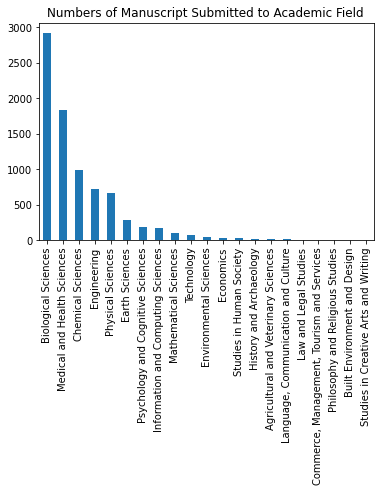

In [36]:
file2['for_name'].value_counts().plot.bar()
plt.title('Numbers of Manuscript Submitted to Academic Field ')

In [37]:
file2

,for_name,for_code
doi,,
10.1038/s41467-019-13371-3,Physical Sciences,2.0
10.1038/s41467-018-03933-2,Biological Sciences,6.0
10.1038/s41467-018-07414-4,Chemical Sciences,3.0
10.1038/s41467-019-10249-2,Physical Sciences,2.0
10.1038/s41467-017-02720-9,Biological Sciences,6.0
...,...,...
10.1038/s41467-018-05894-y,Medical and Health Sciences,11.0
10.1038/s41467-019-10365-z,Psychology and Cognitive Sciences,17.0
10.1038/s41467-019-13535-1,Medical and Health Sciences,11.0


In [38]:
file4 = file4[~file4.index.duplicated(keep=False)]

In [39]:
file4

,corresponding_author_h_index
doi,
10.1038/s41467-018-06932-5,83.0
10.1038/s41467-019-09538-7,121.0
10.1038/s41467-019-11651-6,73.0
10.1038/s41467-019-12788-0,121.0
10.1038/s41467-019-13833-8,121.0
...,...
10.1038/s41467-019-11972-6,78.0
10.1038/s41467-018-05655-x,78.0
10.1038/s41467-019-12081-0,78.0


In [40]:
file13_to_drop = file13.index[~file13.index.isin(file2.index)]

In [41]:
file13_to_drop

Index(['10.1038/s41467-019-12157-x', '10.1038/s41467-019-10852-3',
       '10.1038/s41467-019-12741-1', '10.1038/s41467-018-03545-w',
       '10.1038/s41467-018-06697-x', '10.1038/s41467-018-06105-4',
       '10.1038/s41467-019-12439-4', '10.1038/s41467-018-06898-4',
       '10.1038/s41467-018-04785-6', '10.1038/s41467-018-04405-3',
       ...
       '10.1038/s41467-018-08175-w', '10.1038/s41467-018-04391-6',
       '10.1038/s41467-018-07293-9', '10.1038/s41467-018-06123-2',
       '10.1038/s41467-018-02938-1', '10.1038/s41467-017-02559-0',
       '10.1038/s41467-018-07584-1', '10.1038/s41467-018-06653-9',
       '10.1038/s41467-018-07739-0', '10.1038/s41467-019-13678-1'],
      dtype='object', name='doi', length=2999)

The above shows the indices that need to be dropped to merge file 13 with 2

In [42]:
file13

,title,n_references,n_authors
doi,,,
10.1038/s41467-019-12157-x,Surface acoustic wave photonic devices in silicon on insulator,54,9
10.1038/s41467-018-06688-y,Thermal and electrical signatures of a hydrodynamic electron fluid in tungsten diphosphide,37,10
10.1038/s41467-019-10852-3,Phononic integrated circuitry and spin–orbit interaction of phonons,56,7
10.1038/s41467-019-11924-0,Local Josephson vortex generation and manipulation with a Magnetic Force Microscope,54,15
10.1038/s41467-018-07414-4,A robust zirconium amino acid metal-organic framework for proton conduction,59,11
...,...,...,...
10.1038/s41467-018-07739-0,aPKC controls endothelial growth by modulating c-Myc via FoxO1 DNA-binding ability,71,22
10.1038/s41467-019-08769-y,Single gold-bridged nanoprobes for identification of single point DNA mutations,64,7
10.1038/s41467-019-11237-2,Conditional expression explains molecular evolution of social genes in a microbe,63,11


In [43]:
file13.drop(file13_to_drop, errors='ignore', inplace=True)

In [44]:
file13

,title,n_references,n_authors
doi,,,
10.1038/s41467-018-06688-y,Thermal and electrical signatures of a hydrodynamic electron fluid in tungsten diphosphide,37,10
10.1038/s41467-019-11924-0,Local Josephson vortex generation and manipulation with a Magnetic Force Microscope,54,15
10.1038/s41467-018-07414-4,A robust zirconium amino acid metal-organic framework for proton conduction,59,11
10.1038/s41467-019-10249-2,Ultrafast multi-focus 3-D nano-fabrication based on two-photon polymerization,23,4
10.1038/s41467-018-07828-0,Closure of the Bering Strait caused Mid-Pleistocene Transition cooling,66,11
...,...,...,...
10.1038/s41467-019-08739-4,HIV-1 vaccination by needle-free oral injection induces strong mucosal immunity and protects against SHIV challenge,64,13
10.1038/s41467-019-10160-w,"Author Correction: Study of 300,486 individuals identifies 148 independent genetic loci influencing general cognitive function",0,222
10.1038/s41467-019-08769-y,Single gold-bridged nanoprobes for identification of single point DNA mutations,64,7


In [45]:
file123 = file13.merge(file2,left_index=True,right_index=True)

In [46]:
file123 = file123.dropna()

In [47]:
file123.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8071 entries, 10.1038/s41467-018-06688-y to 10.1038/s41467-018-03395-6
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         8071 non-null   object 
 1   n_references  8071 non-null   int64  
 2   n_authors     8071 non-null   int64  
 3   for_name      8071 non-null   object 
 4   for_code      8071 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 378.3+ KB


In [48]:
file1234 = file123.merge(file4,left_index=True,right_index=True)

In [49]:
file1234

,title,n_references,n_authors,for_name,for_code,corresponding_author_h_index
doi,,,,,,
10.1038/s41467-019-11924-0,Local Josephson vortex generation and manipulation with a Magnetic Force Microscope,54,15,Physical Sciences,2.0,13.0
10.1038/s41467-019-10249-2,Ultrafast multi-focus 3-D nano-fabrication based on two-photon polymerization,23,4,Physical Sciences,2.0,19.0
10.1038/s41467-018-07828-0,Closure of the Bering Strait caused Mid-Pleistocene Transition cooling,66,11,Earth Sciences,4.0,16.0
10.1038/s41467-017-02483-3,Protein phosphatase 5 regulates titin phosphorylation and function at a sarcomere-associated mechanosensor complex in cardiomyocytes,59,11,Biological Sciences,6.0,63.0
10.1038/s41467-019-09506-1,The rise in ocean plastics evidenced from a 60-year time series,25,6,Earth Sciences,4.0,8.0
...,...,...,...,...,...,...
10.1038/s41467-018-04946-7,Excited-state vibrational dynamics toward the polaron in methylammonium lead iodide perovskite,66,10,Chemical Sciences,3.0,95.0
10.1038/s41467-019-08739-4,HIV-1 vaccination by needle-free oral injection induces strong mucosal immunity and protects against SHIV challenge,64,13,Medical and Health Sciences,11.0,40.0
10.1038/s41467-019-10160-w,"Author Correction: Study of 300,486 individuals identifies 148 independent genetic loci influencing general cognitive function",0,222,Biological Sciences,6.0,143.0


In [50]:
file123.isnull().value_counts()

title  n_references  n_authors  for_name  for_code
False  False         False      False     False       8071
dtype: int64

In [51]:
file1234.isnull().value_counts()

title  n_references  n_authors  for_name  for_code  corresponding_author_h_index
False  False         False      False     False     False                           4742
                                                    True                              36
dtype: int64

In [52]:
file1234 = file1234.dropna()

### Initial Exploratory Data Analysis

In [53]:
file1234.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4742 entries, 10.1038/s41467-019-11924-0 to 10.1038/s41467-018-03395-6
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         4742 non-null   object 
 1   n_references                  4742 non-null   int64  
 2   n_authors                     4742 non-null   int64  
 3   for_name                      4742 non-null   object 
 4   for_code                      4742 non-null   float64
 5   corresponding_author_h_index  4742 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 259.3+ KB


In [54]:
file123.describe()

,n_references,n_authors,for_code
count,8071.000000,8071.000000,8071.000000
mean,50.711808,10.864577,7.031471
std,20.086460,11.772750,3.574244
min,0.000000,0.000000,1.000000
25%,40.000000,6.000000,4.000000
50%,53.000000,9.000000,6.000000
75%,65.000000,13.000000,11.000000
max,222.000000,436.000000,22.000000


In [55]:
file1234.describe()

,n_references,n_authors,for_code,corresponding_author_h_index
count,4742.000000,4742.000000,4742.000000,4742.000000
mean,51.488402,9.902151,7.133910,37.320962
std,20.042787,11.434660,3.619884,26.497494
min,0.000000,1.000000,1.000000,1.000000
25%,40.000000,5.000000,5.000000,18.000000
50%,53.000000,8.000000,6.000000,31.000000
75%,66.000000,12.000000,11.000000,49.000000
max,222.000000,436.000000,22.000000,223.000000


#### Correlation Matrix

[Text(0.5, 0, 'n_references'),
 Text(1.5, 0, 'n_authors'),
 Text(2.5, 0, 'for_code'),
 Text(3.5, 0, 'corresponding_author_h_index')]

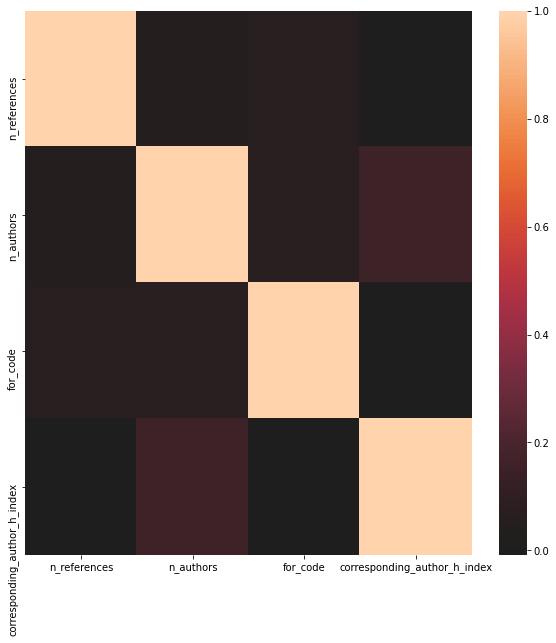

In [56]:
corr = file1234.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, center=0,)
ax.set_xticklabels(ax.get_xticklabels())

Similar statistics despite file1234 being half the size of file123

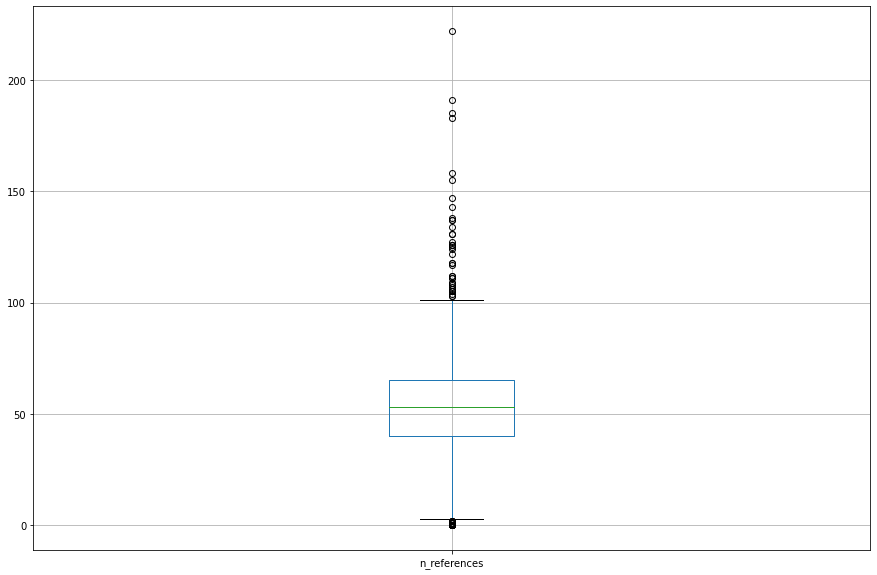

In [57]:
file123.boxplot(column= ['n_references'],figsize=(15,10))

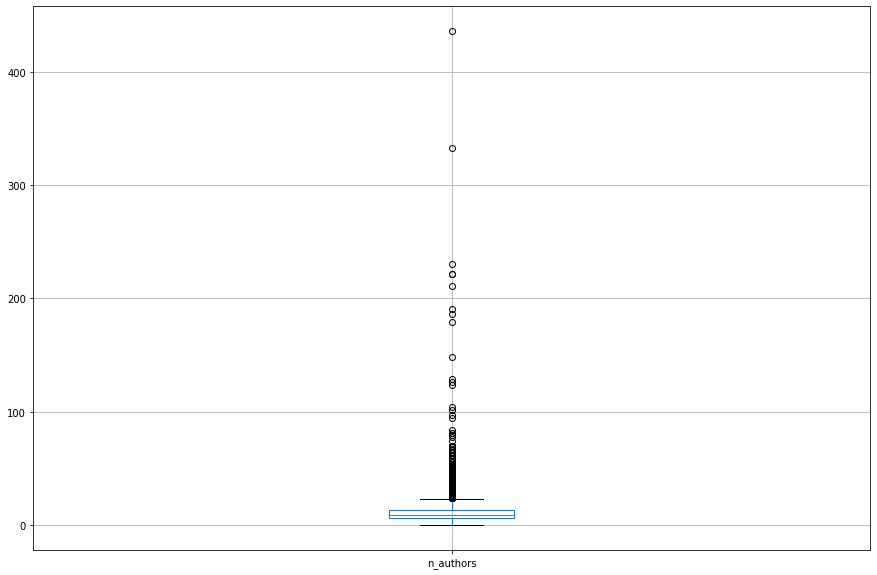

In [58]:
file123.boxplot(column= ['n_authors'],figsize=(15,10))

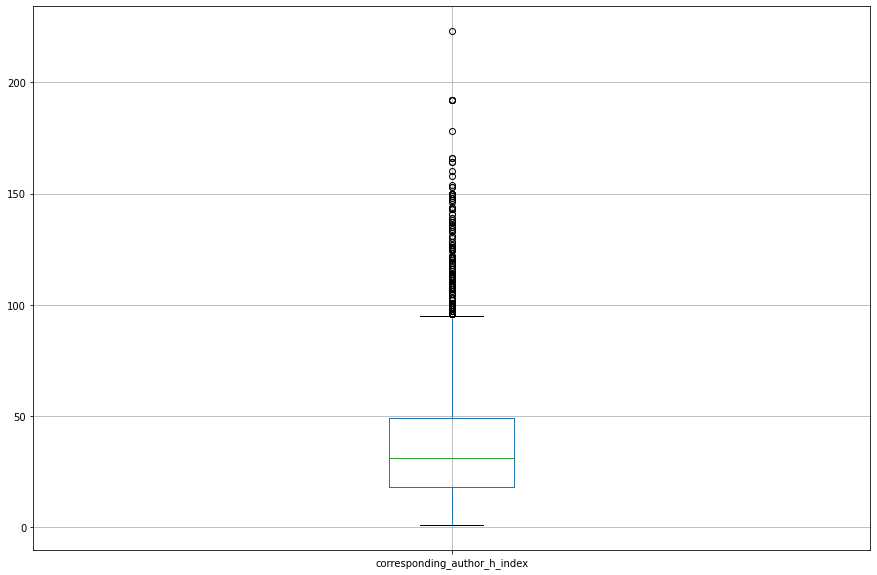

In [59]:
file1234.boxplot(column= ['corresponding_author_h_index'],figsize=(15,10))

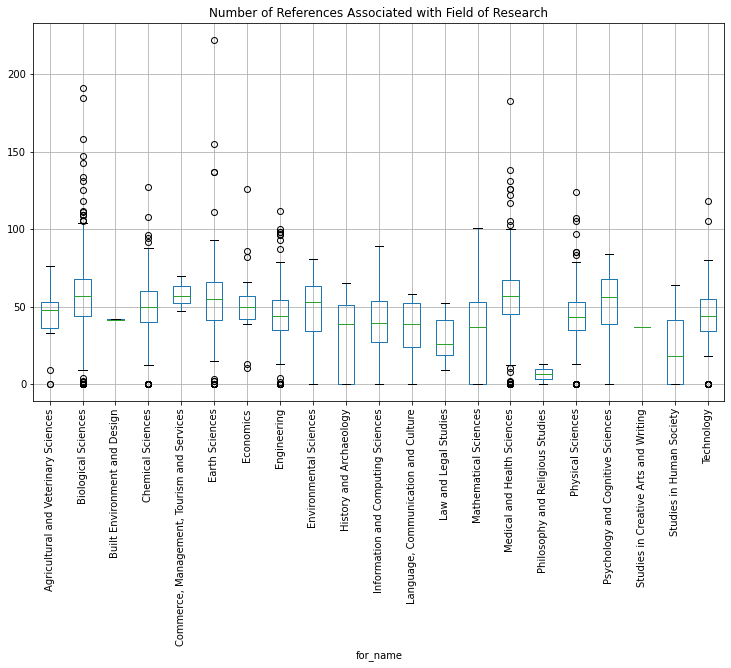

In [60]:
fig, ax = plt.subplots(figsize=(12, 7))
file123.boxplot(column='n_references', by='for_name', ax=ax)
ax.set_title('Number of References Associated with Field of Research')
ax.tick_params(axis='x', labelrotation=90)
plt.suptitle('')
plt.show()

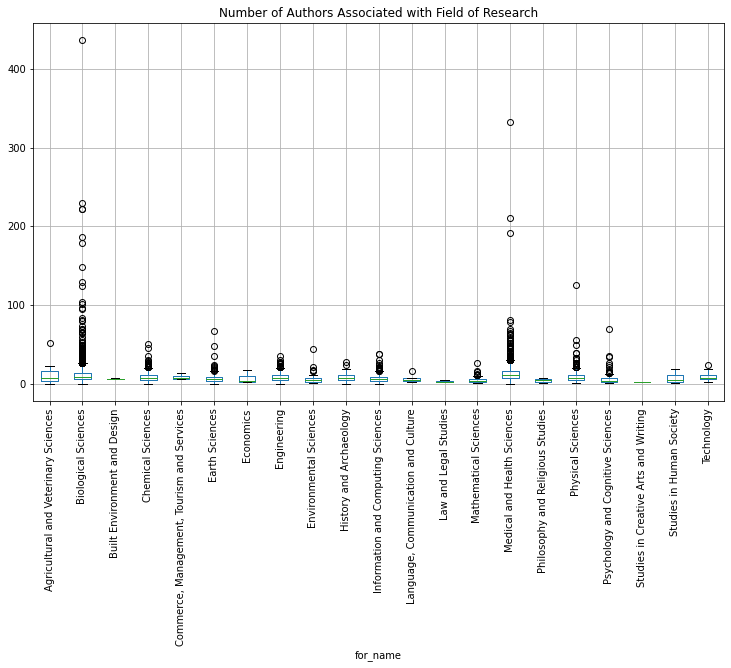

In [61]:
fig, ax = plt.subplots(figsize=(12, 7))
file123.boxplot(column='n_authors', by='for_name', ax=ax)
ax.set_title('Number of Authors Associated with Field of Research')
ax.tick_params(axis='x', labelrotation=90)
plt.suptitle('')
plt.show()

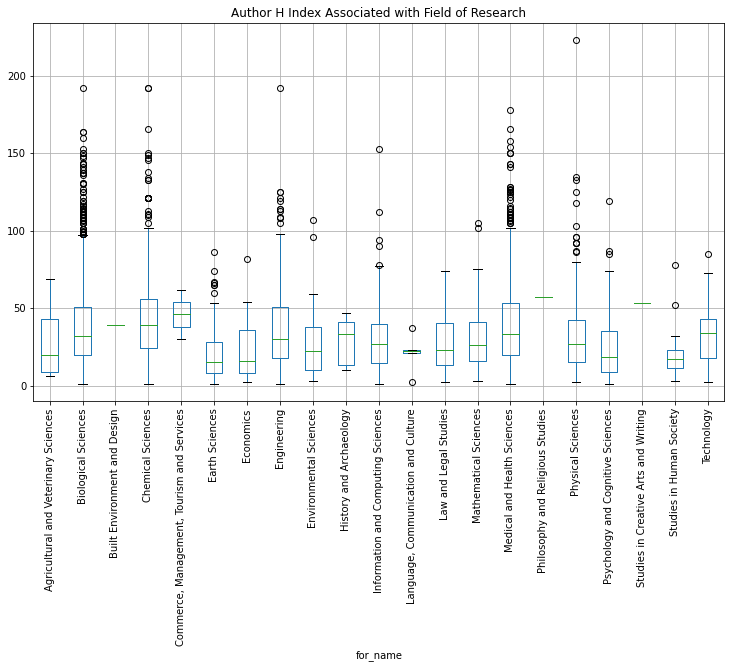

In [62]:
fig, ax = plt.subplots(figsize=(12, 7))
file1234.boxplot(column='corresponding_author_h_index', by='for_name', ax=ax)
ax.set_title('Author H Index Associated with Field of Research')
ax.tick_params(axis='x', labelrotation=90)
plt.suptitle('')
plt.show()

In [63]:
file123[file123.n_authors == 0]

,title,n_references,n_authors,for_name,for_code
doi,,,,,
10.1038/s41467-019-13714-0,A tug-of-war over the mid-latitudes,3,0,Earth Sciences,4.0
10.1038/s41467-018-07733-6,The fine line between performance improvement and device practicality,0,0,Engineering,9.0
10.1038/s41467-018-03586-1,At the human-forest interface,9,0,Agricultural and Veterinary Sciences,7.0
10.1038/s41467-018-04159-y,Building better yeast,10,0,Biological Sciences,6.0
10.1038/s41467-018-06012-8,Reproducibility: let’s get it right from the start,0,0,Medical and Health Sciences,11.0
10.1038/s41467-018-04243-3,Epidemiology is a science of high importance,8,0,History and Archaeology,21.0
10.1038/s41467-018-04085-z,Vaccines work,8,0,Medical and Health Sciences,11.0
10.1038/s41467-018-05227-z,Data sharing and the future of science,9,0,Information and Computing Sciences,8.0
10.1038/s41467-018-04565-2,The future of plastic,13,0,Chemical Sciences,3.0


In [64]:
file123[file123.n_references == 0]

,title,n_references,n_authors,for_name,for_code
doi,,,,,
10.1038/s41467-019-09905-4,Author Correction: Novel mutations in PIEZO1 cause an autosomal recessive generalized lymphatic dysplasia with non-immune hydrops fetalis,0,18,Biological Sciences,6.0
10.1038/s41467-018-05361-8,Publisher Correction: FGF signalling controls the specification of hair placode-derived SOX9 positive progenitors to Merkel cells,0,13,Biological Sciences,6.0
10.1038/s41467-018-05718-z,Author Correction: P53 and mTOR signalling determine fitness selection through cell competition during early mouse embryonic development,0,10,Biological Sciences,6.0
10.1038/s41467-019-08511-8,Author Correction: A disinhibitory mechanism biases Drosophila innate light preference,0,7,Biological Sciences,6.0
10.1038/s41467-018-06064-w,Publisher Correction: Single-shot condensation of exciton polaritons and the hole burning effect,0,12,Information and Computing Sciences,8.0
...,...,...,...,...,...
10.1038/s41467-019-10950-2,Author Correction: Soluble TREM2 ameliorates pathological phenotypes by modulating microglial functions in an Alzheimer’s disease model,0,23,Biological Sciences,6.0
10.1038/s41467-019-12521-x,Building brain-inspired computing,0,0,Medical and Health Sciences,11.0
10.1038/s41467-018-04753-0,"Publisher Correction: 78,000-year-old record of Middle and Later Stone Age innovation in an East African tropical forest",0,28,History and Archaeology,21.0


#### Text exploration

In [65]:
file123['word_count'] = file123['title'].apply(lambda x: len(str(x).split(" "))) 

In [66]:
file123.head()

,title,n_references,n_authors,for_name,for_code,word_count
doi,,,,,,
10.1038/s41467-018-06688-y,Thermal and electrical signatures of a hydrodynamic electron fluid in tungsten diphosphide,37,10,Engineering,9.0,12
10.1038/s41467-019-11924-0,Local Josephson vortex generation and manipulation with a Magnetic Force Microscope,54,15,Physical Sciences,2.0,11
10.1038/s41467-018-07414-4,A robust zirconium amino acid metal-organic framework for proton conduction,59,11,Chemical Sciences,3.0,10
10.1038/s41467-019-10249-2,Ultrafast multi-focus 3-D nano-fabrication based on two-photon polymerization,23,4,Physical Sciences,2.0,8
10.1038/s41467-018-07828-0,Closure of the Bering Strait caused Mid-Pleistocene Transition cooling,66,11,Earth Sciences,4.0,9


In [67]:
file123.word_count.describe()

count    8071.000000
mean       11.412836
std         2.856945
min         1.000000
25%         9.000000
50%        12.000000
75%        14.000000
max        21.000000
Name: word_count, dtype: float64

In [68]:
file123[file123.word_count <= 2]

,title,n_references,n_authors,for_name,for_code,word_count
doi,,,,,,
10.1038/s41467-019-11818-1,TriQuinoline,62,3,Chemical Sciences,3.0,1
10.1038/s41467-019-11850-1,Capillary orbits,28,4,Chemical Sciences,3.0,2
10.1038/s41467-018-04085-z,Vaccines work,8,0,Medical and Health Sciences,11.0,2
10.1038/s41467-018-05666-8,Active nematics,112,4,Engineering,9.0,2
10.1038/s41467-017-02590-1,Ceramic nanowelding,29,14,Engineering,9.0,2


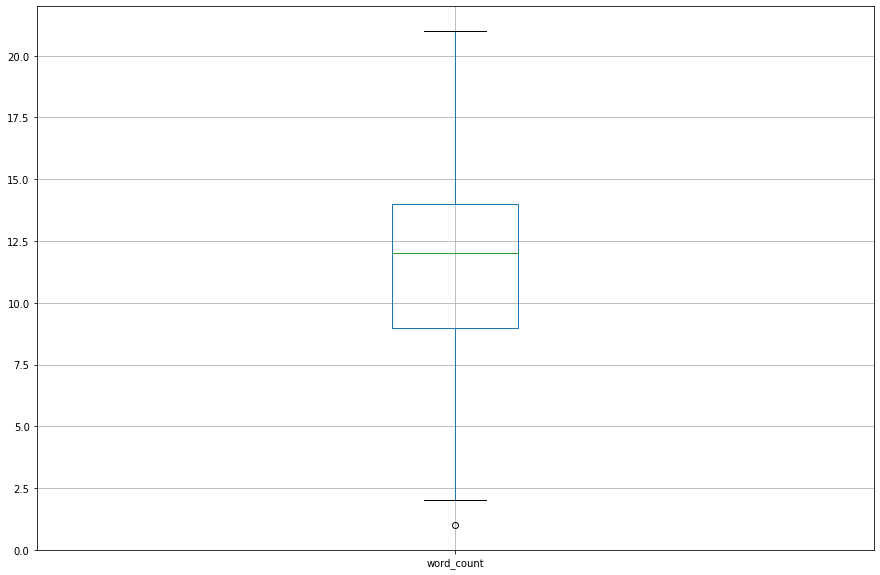

In [69]:
file123.boxplot(column= ['word_count'],figsize=(15,10))

In [70]:
freq = pd.Series(''.join(file123['title']).split())

In [71]:
word_count_q1 = file123['word_count'].quantile(0.25)
word_count_q3 = file123['word_count'].quantile(0.75)
word_count_IQR = word_count_q3 - word_count_q1
word_count_lower = word_count_q1 - (1.5 * word_count_IQR)

In [72]:
word_count_lower

1.5

In [73]:
freq = freq.value_counts(sort=True).to_frame().reset_index()

In [74]:
freq = freq.rename(columns={'index': 'word', 0: 'count'})

In [75]:
freq

,word,count
0,of,4357
1,in,3018
2,and,2813
3,the,1831
4,for,1184
...,...,...
23690,reverts,1
23691,microenvironmentScalable,1
23692,training,1
23693,scienceAsymmetry,1


In [76]:
freq.head(20)

,word,count
0,of,4357
1,in,3018
2,and,2813
3,the,1831
4,for,1184
5,a,1050
6,by,1036
7,to,892
8,with,739
9,Correction:,469


In [77]:
new_words = freq['word'][:40].to_list()

In [78]:
new_words

['of',
 'in',
 'and',
 'the',
 'for',
 'a',
 'by',
 'to',
 'with',
 'Correction:',
 'from',
 'cell',
 'on',
 'is',
 'human',
 'an',
 'via',
 'using',
 'cells',
 'through',
 'during',
 'reveals',
 'at',
 'as',
 'protein',
 'DNA',
 'regulates',
 'cancer',
 'dynamics',
 'quantum',
 'promotes',
 'complex',
 'control',
 'gene',
 'between',
 'into',
 'molecular',
 'carbon',
 'structure',
 'receptor']

In [79]:
word_outliers = freq.word.loc[(freq['count']<=40)] 

In [80]:
word_outliers

183                           can
184                          vivo
185                         metal
186                         genes
187                         small
                   ...           
23690                     reverts
23691    microenvironmentScalable
23692                    training
23693            scienceAsymmetry
23694                  heart-rate
Name: word, Length: 23512, dtype: object

In [81]:
freq.shape

(23695, 2)

In [82]:
# freq[-20:]

### Text Pre-processing

#### Noise Removal

##### Remove other document types

Remove: addenda, editorials, corrections (author, publisher), replies, and retractions that are likely to intoduce noise.

In [83]:
remove_list = file123[file123['title'].str.contains('^correction|author correction|publisher correction|addendum|editorial|reply|retraction', case=False)].index

In [84]:
remove_list

Index(['10.1038/s41467-019-09905-4', '10.1038/s41467-018-05361-8',
       '10.1038/s41467-018-05718-z', '10.1038/s41467-019-08511-8',
       '10.1038/s41467-018-06064-w', '10.1038/s41467-018-03022-4',
       '10.1038/s41467-019-08627-x', '10.1038/ncomms16210',
       '10.1038/s41467-019-08589-0', '10.1038/s41467-017-02303-8',
       ...
       '10.1038/s41467-019-09912-5', '10.1038/s41467-018-04655-1',
       '10.1038/s41467-019-10072-9', '10.1038/s41467-018-07428-y',
       '10.1038/s41467-019-08920-9', '10.1038/s41467-019-10559-5',
       '10.1038/s41467-019-10950-2', '10.1038/s41467-018-04753-0',
       '10.1038/s41467-018-06643-x', '10.1038/s41467-019-10160-w'],
      dtype='object', name='doi', length=473)

In [85]:
file123_df = file123.drop(remove_list)

In [86]:
file123_df

,title,n_references,n_authors,for_name,for_code,word_count
doi,,,,,,
10.1038/s41467-018-06688-y,Thermal and electrical signatures of a hydrodynamic electron fluid in tungsten diphosphide,37,10,Engineering,9.0,12
10.1038/s41467-019-11924-0,Local Josephson vortex generation and manipulation with a Magnetic Force Microscope,54,15,Physical Sciences,2.0,11
10.1038/s41467-018-07414-4,A robust zirconium amino acid metal-organic framework for proton conduction,59,11,Chemical Sciences,3.0,10
10.1038/s41467-019-10249-2,Ultrafast multi-focus 3-D nano-fabrication based on two-photon polymerization,23,4,Physical Sciences,2.0,8
10.1038/s41467-018-07828-0,Closure of the Bering Strait caused Mid-Pleistocene Transition cooling,66,11,Earth Sciences,4.0,9
...,...,...,...,...,...,...
10.1038/s41467-017-02270-0,Ultrasensitive reversible chromophore reaction of BODIPY functions as high ratio double turn on probe,48,15,Chemical Sciences,3.0,14
10.1038/s41467-019-08739-4,HIV-1 vaccination by needle-free oral injection induces strong mucosal immunity and protects against SHIV challenge,64,13,Medical and Health Sciences,11.0,15
10.1038/s41467-019-08769-y,Single gold-bridged nanoprobes for identification of single point DNA mutations,64,7,Chemical Sciences,3.0,10


##### Correlation Matrix

[Text(0.5, 0, 'n_references'),
 Text(1.5, 0, 'n_authors'),
 Text(2.5, 0, 'for_code'),
 Text(3.5, 0, 'word_count')]

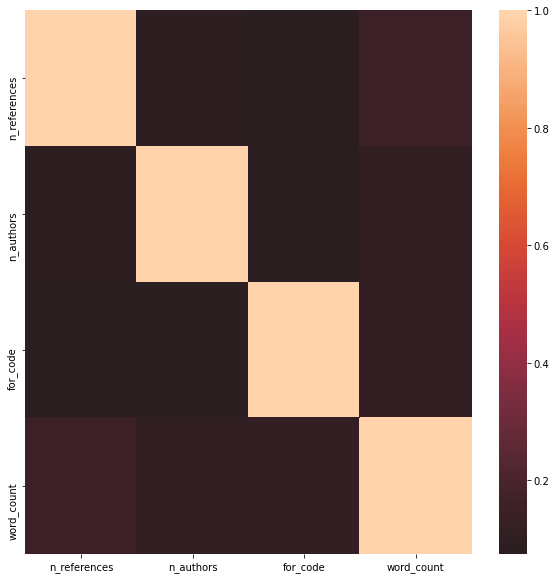

In [87]:
corr = file123_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, center=0,)
ax.set_xticklabels(ax.get_xticklabels())

##### Convert all titles to lower case and remove non-alphabetical, word characters.

In [88]:
file123_df['title'] = file123_df['title'].str.replace('[^a-zA-Z]', ' ')
file123_df['title'] = file123_df['title'].str.replace('(\\d|\\W)+',' ')
file123_df['title'] = file123_df['title'].str.lower()

<ipython-input-88-8b7a550c37ed>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  file123_df['title'] = file123_df['title'].str.replace('[^a-zA-Z]', ' ')
<ipython-input-88-8b7a550c37ed>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  file123_df['title'] = file123_df['title'].str.replace('(\\d|\\W)+',' ')


In [89]:
file123_df

,title,n_references,n_authors,for_name,for_code,word_count
doi,,,,,,
10.1038/s41467-018-06688-y,thermal and electrical signatures of a hydrodynamic electron fluid in tungsten diphosphide,37,10,Engineering,9.0,12
10.1038/s41467-019-11924-0,local josephson vortex generation and manipulation with a magnetic force microscope,54,15,Physical Sciences,2.0,11
10.1038/s41467-018-07414-4,a robust zirconium amino acid metal organic framework for proton conduction,59,11,Chemical Sciences,3.0,10
10.1038/s41467-019-10249-2,ultrafast multi focus d nano fabrication based on two photon polymerization,23,4,Physical Sciences,2.0,8
10.1038/s41467-018-07828-0,closure of the bering strait caused mid pleistocene transition cooling,66,11,Earth Sciences,4.0,9
...,...,...,...,...,...,...
10.1038/s41467-017-02270-0,ultrasensitive reversible chromophore reaction of bodipy functions as high ratio double turn on probe,48,15,Chemical Sciences,3.0,14
10.1038/s41467-019-08739-4,hiv vaccination by needle free oral injection induces strong mucosal immunity and protects against shiv challenge,64,13,Medical and Health Sciences,11.0,15
10.1038/s41467-019-08769-y,single gold bridged nanoprobes for identification of single point dna mutations,64,7,Chemical Sciences,3.0,10


##### Imbalanced categories

In [90]:
file123_df['for_name'].value_counts()

Biological Sciences                           2752
Medical and Health Sciences                   1737
Chemical Sciences                              959
Engineering                                    684
Physical Sciences                              623
Earth Sciences                                 270
Psychology and Cognitive Sciences              167
Information and Computing Sciences             146
Mathematical Sciences                           70
Technology                                      66
Environmental Sciences                          40
Economics                                       25
Studies in Human Society                        17
Agricultural and Veterinary Sciences            12
History and Archaeology                         12
Language, Communication and Culture              6
Law and Legal Studies                            5
Commerce, Management, Tourism and Services       3
Built Environment and Design                     2
Philosophy and Religious Studie

In [91]:
file123_df = file123_df[file123_df['for_name'].isin(['Biological Sciences','Medical and Health Sciences','Chemical Sciences','Engineering','Information and Computing Sciences','Physical Sciences','Earth Sciences','Psychology and Cognitive Sciences'])]

In [92]:
file123_df['for_name'].value_counts()

Biological Sciences                   2752
Medical and Health Sciences           1737
Chemical Sciences                      959
Engineering                            684
Physical Sciences                      623
Earth Sciences                         270
Psychology and Cognitive Sciences      167
Information and Computing Sciences     146
Name: for_name, dtype: int64

##### Stop Words 

In [93]:
stop_words = set(stopwords.words('english'))

In [94]:
# stop_words2 = stop_words.union(new_words)

In [95]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [96]:
# stop_words2

In [97]:
# stop_words3 = stop_words2.union(word_outliers)

In [98]:
# stop_words3

In [99]:
y = file123_df['for_name']

In [100]:
x = file123_df['title']

#### Normalisation

##### Stemming & Lemmatization

In [101]:
def cleanData(text, remove_stops = False, stemming = False, lemmatization = False, short = False):
    
    txt = str(text)
    
#     see 2.3.1.3   
#     txt = re.sub(r'[^A-Za-z]',r' ',txt)
#     txt = re.sub('(\\d|\\W)+',' ',txt)
#     if lowercase:
#     txt = txt.lower()
#     " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stop_words])
   
    if stemming:
#         st = PorterStemmer()
        st = SnowballStemmer('english')
        txt = " ".join([st.stem(w) for w in txt.split()])
    
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in txt.split()])
    
    if short:
        txt = " ".join([w for w in txt.split() if len(w)>=3])
    
    return txt

In [102]:
x_clean = x.map(lambda x: cleanData(x, remove_stops=True, stemming=True, lemmatization = True, short=True))

### Split Dataset

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x_clean, y,test_size=0.2,stratify=y, random_state=2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5870,), (1468,), (5870,), (1468,))

In [104]:
x_test

doi
10.1038/s41467-018-04239-z                             sema plxncl signal trigger activ depend olfactori synaps format
10.1038/s41467-019-13023-6                                        atom mechan strong interact graphen sapphir interfac
10.1038/s41467-018-07797-4                                        break speed limit multimod fast scan dna endonucleas
10.1038/s41467-017-02013-1                                    structur guid design hsp termin isoform select inhibitor
10.1038/s41467-019-09847-x                                         self organ plk regul symmetri break centriol duplic
                                                                        ...                                           
10.1038/s41467-019-09332-5                                    frequent extrem climat event stabil reindeer popul dynam
10.1038/s41467-019-13106-4                                                kras regul small non code rnas snare protein
10.1038/s41467-019-11014-1    zwitterion nea

In [105]:
x_train

doi
10.1038/s41467-018-06640-0                                                              cancer exosom induc tumor innerv
10.1038/s41467-019-09085-1    systemat comparison respiratori syncyti virus induc memori cell respons two anatom compart
10.1038/s41467-019-11925-z         conduct carbon nanofib interpenetr graphen architectur ultra stabl sodium ion batteri
10.1038/s41467-018-07873-9                                              experiment evid symmetri break transit path time
10.1038/s41467-018-03958-7                               aerodynam generat electr field turbul lade charg inerti particl
                                                                         ...                                            
10.1038/s41467-017-02642-6     interneuron specif signal evok distinct somatostatin mediat respons adult cortic astrocyt
10.1038/s41467-019-09716-7                                                                  humanis mous genom piec piec
10.1038/s41467-017-02677-9  

### Count Vectorisation

In [106]:
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
x_train_cvm=cv.fit_transform(x_train)

In [107]:
x_test_cvm = cv.transform(x_test)

### TF-IDF Vectorisation

In [108]:
tv = TfidfVectorizer(use_idf=True, min_df=3,max_df=0.9, stop_words=stop_words, max_features=1000,ngram_range=(1,3))

In [109]:
x_train_m = tv.fit_transform(x_train)

In [110]:
first_x_train_m=x_train_m[0] 

In [111]:
df = pd.DataFrame(first_x_train_m.T.todense(), index=tv.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
tumor,0.629877
cancer,0.563699
induc,0.534321
acceler,0.000000
persist,0.000000
...,...
flexibl,0.000000
flow,0.000000
fluctuat,0.000000
fluid,0.000000


In [112]:
list(tv.vocabulary_.keys())[:10]

['cancer',
 'induc',
 'tumor',
 'systemat',
 'respiratori',
 'virus',
 'memori',
 'cell',
 'respons',
 'two']

In [113]:
x_train_m.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [114]:
x_test_m = tv.transform(x_test)

In [115]:
x_test_m

<1468x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 8825 stored elements in Compressed Sparse Row format>

In [116]:
print(tv.get_feature_names())

['acceler', 'access', 'accumul', 'acetyl', 'acid', 'across', 'act', 'actin', 'action', 'activ', 'actuat', 'acut', 'adapt', 'addit', 'adhes', 'adult', 'affect', 'african', 'age', 'aggreg', 'air', 'alloster', 'allow', 'alloy', 'alpha', 'alter', 'altern', 'amino', 'amino acid', 'amyloid', 'analys', 'analysi', 'anion', 'anisotrop', 'anomal', 'anti', 'antibiot', 'antibodi', 'antiferromagnet', 'antigen', 'apoptosi', 'applic', 'approach', 'aqueous', 'arabidopsi', 'architectur', 'arctic', 'area', 'aromat', 'array', 'artifici', 'assembl', 'assess', 'assist', 'associ', 'associ studi', 'asymmetr', 'atmospher', 'atom', 'atp', 'attenu', 'auditori', 'autonom', 'autophagi', 'axi', 'bacteri', 'bacteria', 'balanc', 'band', 'barrier', 'basal', 'base', 'basi', 'batteri', 'behavior', 'behaviour', 'bias', 'bind', 'bind protein', 'biolog', 'biosynthesi', 'black', 'block', 'blockad', 'blood', 'bodi', 'bond', 'bone', 'boost', 'boundari', 'brain', 'branch', 'break', 'breast', 'breast cancer', 'broad', 'build',

In [117]:
y

doi
10.1038/s41467-018-06688-y                    Engineering
10.1038/s41467-019-11924-0              Physical Sciences
10.1038/s41467-018-07414-4              Chemical Sciences
10.1038/s41467-019-10249-2              Physical Sciences
10.1038/s41467-018-07828-0                 Earth Sciences
                                         ...             
10.1038/s41467-017-02270-0              Chemical Sciences
10.1038/s41467-019-08739-4    Medical and Health Sciences
10.1038/s41467-019-08769-y              Chemical Sciences
10.1038/s41467-019-11237-2            Biological Sciences
10.1038/s41467-018-03395-6            Biological Sciences
Name: for_name, Length: 7338, dtype: object

Text(0.5, 1.0, 'Sparse Matrix Sample')

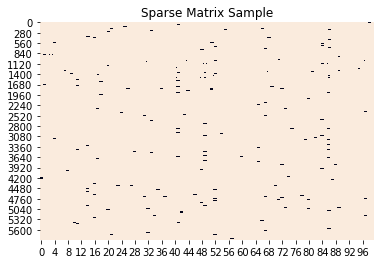

In [118]:
sns.heatmap(x_train_m.todense()[:,np.random.randint(0,x_train_m.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [119]:
y_train

doi
10.1038/s41467-018-06640-0    Medical and Health Sciences
10.1038/s41467-019-09085-1    Medical and Health Sciences
10.1038/s41467-019-11925-z                    Engineering
10.1038/s41467-018-07873-9              Chemical Sciences
10.1038/s41467-018-03958-7                    Engineering
                                         ...             
10.1038/s41467-017-02642-6    Medical and Health Sciences
10.1038/s41467-019-09716-7            Biological Sciences
10.1038/s41467-017-02677-9    Medical and Health Sciences
10.1038/s41467-019-08865-z            Biological Sciences
10.1038/s41467-019-09740-7                    Engineering
Name: for_name, Length: 5870, dtype: object

In [120]:
np.unique(y)

array(['Biological Sciences', 'Chemical Sciences', 'Earth Sciences',
       'Engineering', 'Information and Computing Sciences',
       'Medical and Health Sciences', 'Physical Sciences',
       'Psychology and Cognitive Sciences'], dtype=object)

## Modelling

### Multinomial Naive Bayes (MultinomialNB)

#### Using Word Count Vectors 

(See section 2.5 Count Vectorisation)

In [121]:
classifier1 = MultinomialNB(alpha=1.0).fit(x_train_cvm, y_train)

In [122]:
predict1 = classifier1.predict(x_test_cvm)

In [123]:
metrics.accuracy_score(y_test, predict1)

0.717983651226158

In [124]:
print(classification_report(y_test, predict1)) 

                                    precision    recall  f1-score   support

               Biological Sciences       0.78      0.84      0.81       551
                 Chemical Sciences       0.64      0.70      0.67       192
                    Earth Sciences       0.74      0.57      0.65        54
                       Engineering       0.51      0.46      0.48       137
Information and Computing Sciences       0.86      0.21      0.33        29
       Medical and Health Sciences       0.75      0.78      0.77       347
                 Physical Sciences       0.60      0.61      0.61       125
 Psychology and Cognitive Sciences       0.91      0.30      0.45        33

                          accuracy                           0.72      1468
                         macro avg       0.73      0.56      0.60      1468
                      weighted avg       0.72      0.72      0.71      1468



In [125]:
cm1 = confusion_matrix(y_test, predict1)
cm1

array([[463,  14,   5,   4,   0,  64,   1,   0],
       [ 16, 134,   2,  26,   0,   3,  11,   0],
       [  7,   9,  31,   4,   0,   0,   3,   0],
       [ 13,  28,   3,  63,   0,   6,  24,   0],
       [ 10,   0,   0,   2,   6,   2,   9,   0],
       [ 66,   3,   0,   3,   1, 271,   2,   1],
       [ 10,  17,   1,  20,   0,   1,  76,   0],
       [  6,   3,   0,   1,   0,  13,   0,  10]])

#### Using Word Frequency Vectors 

(See section 2.6 TF-IDF Vectorisation)

In [126]:
classifier2 = MultinomialNB(alpha=1.0).fit(x_train_m, y_train)

In [127]:
predict2 = classifier2.predict(x_test_m)

In [128]:
metrics.accuracy_score(y_test, predict2)

0.6634877384196185

In [129]:
print(classification_report(y_test, predict2)) 

                                    precision    recall  f1-score   support

               Biological Sciences       0.68      0.87      0.76       551
                 Chemical Sciences       0.65      0.61      0.63       192
                    Earth Sciences       0.73      0.20      0.32        54
                       Engineering       0.50      0.38      0.43       137
Information and Computing Sciences       0.67      0.07      0.12        29
       Medical and Health Sciences       0.72      0.70      0.71       347
                 Physical Sciences       0.57      0.52      0.54       125
 Psychology and Cognitive Sciences       1.00      0.09      0.17        33

                          accuracy                           0.66      1468
                         macro avg       0.69      0.43      0.46      1468
                      weighted avg       0.67      0.66      0.64      1468



In [130]:
cm2 = confusion_matrix(y_test, predict2)
cm2

array([[480,   7,   3,   1,   0,  58,   2,   0],
       [ 31, 117,   0,  26,   0,   5,  13,   0],
       [ 27,   8,  11,   4,   0,   3,   1,   0],
       [ 28,  25,   0,  52,   0,   7,  25,   0],
       [ 13,   3,   0,   2,   2,   2,   7,   0],
       [ 94,   5,   0,   1,   1, 244,   2,   0],
       [ 23,  15,   1,  18,   0,   3,  65,   0],
       [ 12,   1,   0,   0,   0,  17,   0,   3]])

### Support Vector Classifier (SVC)

In [131]:
svc = SVC(class_weight='balanced') 
svc.fit(x_train_cvm, y_train) 
predict3 = svc.predict(x_test_cvm) 
print(classification_report(y_test, predict3)) 

                                    precision    recall  f1-score   support

               Biological Sciences       0.80      0.74      0.77       551
                 Chemical Sciences       0.61      0.58      0.59       192
                    Earth Sciences       0.66      0.70      0.68        54
                       Engineering       0.48      0.56      0.52       137
Information and Computing Sciences       0.48      0.34      0.40        29
       Medical and Health Sciences       0.73      0.74      0.74       347
                 Physical Sciences       0.52      0.66      0.58       125
 Psychology and Cognitive Sciences       0.75      0.55      0.63        33

                          accuracy                           0.68      1468
                         macro avg       0.63      0.61      0.61      1468
                      weighted avg       0.69      0.68      0.68      1468



### Grid Search Cross Validation (GridSearchCV)

In [132]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
   
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
grid.fit(x_train_cvm, y_train) 
 
print(grid.best_params_) 
grid_predictions = grid.predict(x_test_cvm) 
   
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
                                    precision    recall  f1-score   support

               Biological Sciences       0.71      0.83      0.77       551
                 Chemical Sciences       0.62      0.59      0.61       192
                    Earth Sciences       0.78      0.59      0.67        54
                       Engineering       0.50      0.46      0.48       137
Information and Computing Sciences       0.53      0.34      0.42        29
       Medical and Health Sciences       0.75      0.68      0.71       347
                 Physical Sciences       0.53      0.51      0.52       125
 Psychology and Cognitive Sciences       0.89      0.48      0.63        33

                          accuracy                           0.68      1468
                         macro avg       0.66      0.56      0.60      1468
                      weighted avg       0.68      0.68  

### Multi-layer Perceptron Classifier (MLPClassifier)

In [133]:
mlp = MLPClassifier(solver='adam', alpha=1e-5, random_state=1).fit(x_train_cvm, y_train)

In [134]:
mlp_predict = mlp.predict(x_test_cvm)

In [135]:
mlp_predict

array(['Medical and Health Sciences', 'Physical Sciences',
       'Physical Sciences', ..., 'Chemical Sciences',
       'Biological Sciences', 'Biological Sciences'], dtype='<U34')

In [136]:
print(confusion_matrix(y_test,mlp_predict))

[[440  22   4   9   3  67   5   1]
 [ 17 118   2  26   0   6  22   1]
 [  7   5  34   4   1   0   3   0]
 [  9  29   3  58   2   6  30   0]
 [  4   0   0   2  14   1   7   1]
 [ 80   7   0   5   2 248   3   2]
 [  8  17   1  20   3   2  74   0]
 [  4   2   0   1   1   7   0  18]]


In [137]:
print(classification_report(y_test, mlp_predict))

                                    precision    recall  f1-score   support

               Biological Sciences       0.77      0.80      0.79       551
                 Chemical Sciences       0.59      0.61      0.60       192
                    Earth Sciences       0.77      0.63      0.69        54
                       Engineering       0.46      0.42      0.44       137
Information and Computing Sciences       0.54      0.48      0.51        29
       Medical and Health Sciences       0.74      0.71      0.73       347
                 Physical Sciences       0.51      0.59      0.55       125
 Psychology and Cognitive Sciences       0.78      0.55      0.64        33

                          accuracy                           0.68      1468
                         macro avg       0.65      0.60      0.62      1468
                      weighted avg       0.69      0.68      0.68      1468



In [138]:
mlp.coefs_

[array([[ 4.48901356e-02, -1.60506833e-02,  3.21220716e-02, ...,
          5.32835009e-02, -5.50099072e-02, -1.00209734e-02],
        [ 2.17555873e-02, -9.69515158e-03,  5.25614922e-02, ...,
          1.79244623e-02,  4.00171193e-06,  8.04414426e-03],
        [-5.18090962e-02,  6.82414081e-02, -2.46925313e-02, ...,
         -9.04466718e-02, -3.27055310e-02, -7.09761479e-02],
        ...,
        [-2.24402915e-02, -1.21680449e-01,  5.76501995e-02, ...,
         -1.13902884e-02, -5.14753565e-03,  4.33464399e-02],
        [ 5.04448923e-02, -2.72181362e-02,  3.61035621e-02, ...,
          8.11621515e-03, -1.25440930e-02, -6.11974497e-02],
        [ 9.74157180e-03, -2.45409215e-02,  1.36254058e-02, ...,
          1.57951137e-02, -4.68033781e-02, -5.33716872e-02]]),
 array([[ 0.19229299,  0.16243035, -0.43439318,  0.1090138 , -0.42320789,
          0.22699544, -0.5276618 , -0.37861585],
        [-0.62100785,  0.53116963, -0.35925421, -0.32221173,  0.26501019,
         -0.64964217,  0.3662552

### Synthetic Minority Oversampling Technique (SMOTE)

(17608, 10000)

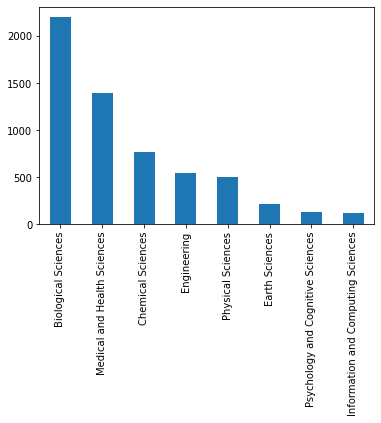

In [139]:
sm = SMOTE(random_state=2)
x_train_cvm_smote, y_train_smote = sm.fit_resample(x_train_cvm, y_train)

pd.Series(y_train).value_counts().plot.bar()

x_train_cvm.shape
x_train_cvm_smote.shape

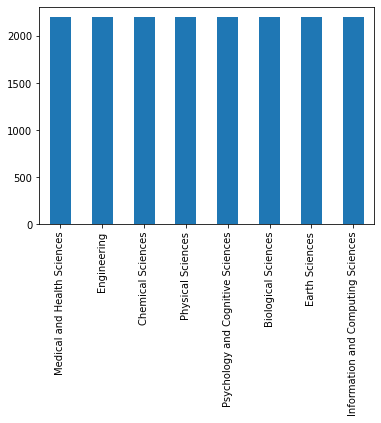

In [140]:
pd.Series(y_train_smote).value_counts().plot.bar()

#### SMOTE & MultinomialNB

In [141]:
classifier2 = MultinomialNB(alpha=1.0).fit(x_train_cvm_smote, y_train_smote)

In [142]:
predict_smote = classifier2.predict(x_test_cvm)

In [143]:
np.mean(predict_smote == y_test)
print(classification_report(y_test, predict_smote)) 

                                    precision    recall  f1-score   support

               Biological Sciences       0.85      0.79      0.82       551
                 Chemical Sciences       0.66      0.68      0.67       192
                    Earth Sciences       0.70      0.81      0.75        54
                       Engineering       0.51      0.51      0.51       137
Information and Computing Sciences       0.42      0.45      0.43        29
       Medical and Health Sciences       0.78      0.80      0.79       347
                 Physical Sciences       0.58      0.64      0.61       125
 Psychology and Cognitive Sciences       0.74      0.70      0.72        33

                          accuracy                           0.73      1468
                         macro avg       0.66      0.67      0.66      1468
                      weighted avg       0.74      0.73      0.73      1468



In [144]:
metrics.accuracy_score(y_test, predict_smote)

0.7316076294277929

#### SMOTE & SVC

In [145]:
svc2 = SVC(class_weight='balanced') 
svc2.fit(x_train_cvm_smote, y_train_smote) 

predictions2 = svc2.predict(x_test_cvm) 
print(classification_report(y_test, predictions2)) 

                                    precision    recall  f1-score   support

               Biological Sciences       0.47      0.91      0.62       551
                 Chemical Sciences       0.58      0.17      0.27       192
                    Earth Sciences       0.17      0.04      0.06        54
                       Engineering       0.34      0.15      0.21       137
Information and Computing Sciences       0.50      0.10      0.17        29
       Medical and Health Sciences       0.66      0.40      0.50       347
                 Physical Sciences       0.58      0.22      0.32       125
 Psychology and Cognitive Sciences       1.00      0.12      0.22        33

                          accuracy                           0.50      1468
                         macro avg       0.54      0.26      0.29      1468
                      weighted avg       0.53      0.50      0.44      1468



#### SMOTE & MLPClassifier

In [146]:
mlp2 = MLPClassifier(solver='adam', max_iter=500,alpha=1e-5, random_state=1).fit(x_train_cvm_smote, y_train_smote)

In [147]:
mlp_predict = mlp.predict(x_test_cvm)

In [148]:
print(classification_report(y_test, mlp_predict))

                                    precision    recall  f1-score   support

               Biological Sciences       0.77      0.80      0.79       551
                 Chemical Sciences       0.59      0.61      0.60       192
                    Earth Sciences       0.77      0.63      0.69        54
                       Engineering       0.46      0.42      0.44       137
Information and Computing Sciences       0.54      0.48      0.51        29
       Medical and Health Sciences       0.74      0.71      0.73       347
                 Physical Sciences       0.51      0.59      0.55       125
 Psychology and Cognitive Sciences       0.78      0.55      0.64        33

                          accuracy                           0.68      1468
                         macro avg       0.65      0.60      0.62      1468
                      weighted avg       0.69      0.68      0.68      1468



## Observations

- Low correlation between features other than 'title'. See correlation matrix section 2.3.1.2
- Duplicated manuscript submissions in more than one category. Adjacent / overlapping categories (e.g. Biological sciences and Medical and Health Sciences). Is this an intended feature of the subbmission platform? If no, remove ability to submit more than once. If yes, overlapping fields could suggest it might be worth reviewing current journals, to see whether any could be amalgamated into new fields/journals.
- Low manuscript submissions in a number of fields outside of the 8 used in modelling. Is this the norm for those fields? 

## Model Predictions


- Used data (for train/test) from the top 8 academic fields with regards to manuscript submissions (Biological Sciences, Medical and Health Sciences, Chemical Sciences, Engineering, Physical Sciences, Earth Sciences, Psychology and Cognitive Sciences,Information and Computing Sciences). Models performed poorly at classifying those outside of these fields, due to fewer sample numbers. In practice, as these top 8 fields encompassed 97% of manuscripts (after processing data), it would be feasible to manually check other submissions outside of this selection, until the classifier can be improved upon.   
- Word count vector seems to have performed better than word frequency vector. This isn't surprising as we are dealing with short titles. TFIDF would perhaps be more useful with longer documents, such as full articles, where words may have a higher chance of beinng repeated in the text. F1 scores for the MultinomialNB model were better using count based vectorisation rather than frequency  
- Several models performed fairly well. SV and MLP classifiers performed similarly, despite having slightly lower accuracy. 
- Used SMOTE as a way of balancing the data, by adding synthetic data to minority classes. This slightly improved the MultinomialNB model. F1 scores ranged between 0.43 and 0.82 with an accuracy: 0.73.
                         

## Future Work

- Mixed models on training data. Some models, such as naive bayes, better with sparse data, perhaps these are better when used for categories where there are less submissions / Boosting.
- Sparsity / dimension reduction
- Augment data. 
- Compile comprehensive domain specific corpuses.
- An alternative to augmenting the data: use a larger dataset, outside of the 2018-2019 dataset used here, particularly as a means to balance data across all classes.
- Class weights e.g. class-specific attribute weighted naive Bayes (CAWNB)
- Utilise word positions as opposed to 'bag of words'. May not have too much of an effect as working with relatively short titles but could be used in conjunction with data from manuscript abstracts. Could be useful in distinguishing between overlapping fields/those submitted into more than one field.
